In [95]:
import os
import re
from glob import glob
from pathlib import Path
import math

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
 
import torch
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
from torch.optim import Adam

## STEP 0 – Make sure the dataset matches what VGG16 expects

* Images are **3×224×224**
* Pixel values are normalized with **ImageNet statistics**

 ```python
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  ```

### 0.1 StrawberryDiseaseDataset to provide VGG16 like data to the network

In [96]:
categories = {  # name in filename -> numeric id
    "angular_leafspot": 0,
    "leaf_spot": 1,
    "anthracnose_fruit_rot": 2,
    "blossom_blight": 3,
    "powdery_mildew_fruit": 4,
    "powdery_mildew_leaf": 5,
    "gray_mold": 6,
}
label_to_name = {
    'angular_leafspot'     : 'Angular Leafspot',
    'leaf_spot'            : 'Leaf spot',
    'anthracnose_fruit_rot': 'Anthracnose fruit rot',
    'blossom_blight'       : 'Blossom blight',
    'powdery_mildew_fruit' : 'Powdery mildew fruit',
    'powdery_mildew_leaf'  : 'Powdery mildew leaf',
    'gray_mold'            : 'Gray mold'
}

class StrawberryDiseaseDataset(Dataset):
    def __init__(self, pattern, mean=None, std=None, augment=False):
        self.files = glob(pattern)
        self.mean = mean
        self.std = std
        self.augment = augment
        
        self.name_to_idx = categories
        
        self.classes = [
            label_to_name[name] for name, idx in sorted(self.name_to_idx.items(), key=lambda kv: kv[1]) # returning th esorted list of classes
        ]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img_pth = self.files[index]
        
        # get image 
        img = cv2.imread(img_pth)
        if img is None:
            raise FileNotFoundError("Couldn't read image")
        
        # resize to 224×224 as required by VGG16
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              
        
        # TODO: if self.augment: apply augmentations here
        
        # to float32 in [0, 1]
        img = img.astype(np.float32) / 255.0   # [0, 1]
        # (H, W, C) -> (C, H, W)
        img = np.transpose(img, (2, 0, 1))  # (C, H, W)
        
        # get label
        img_fl_nm = os.path.basename(img_pth)
        m = re.search(r"\d", img_fl_nm)
        if m is None:
            raise ValueError(f"Couldn't parse label from filename: {img_fl_nm}")
        idx = m.start() if m else None
        lbl_nm = img_fl_nm[:idx]
        lbl = self.name_to_idx[lbl_nm]    # numeric label
           
        # convert to tensor
        x = torch.from_numpy(img) # float32 already
        
        if self.mean is not None and self.std is not None:
            x = (x - self.mean)/self.std
                    
        y = torch.tensor(lbl, dtype=torch.long) # NOTE: scalar int, not [lbl]
        
        return x, y

### 0.2 Use ImageNet mean/std

In [97]:
root_path = "/home/onkar/Good/modern-cv-with-pytorch/images/StrawberryDiseaseCOCO"

imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

ds_train = StrawberryDiseaseDataset(root_path + "/train" + "/*.jpg", mean=imagenet_mean, std=imagenet_std, augment=False)
ds_valid = StrawberryDiseaseDataset(root_path + "/valid" + "/*.jpg", mean=imagenet_mean, std=imagenet_std, augment=False)
ds_test  = StrawberryDiseaseDataset(root_path + "/test" + "/*.jpg", mean=imagenet_mean, std=imagenet_std, augment=False)

x, y = ds_train[22]
print(f"x.shape : {x.shape}, y.shape: {y.shape}")
print(f"{x[0].min()} -> {x[0].max()}")


x.shape : torch.Size([3, 224, 224]), y.shape: torch.Size([])
-1.9295316934585571 -> 2.1975338459014893


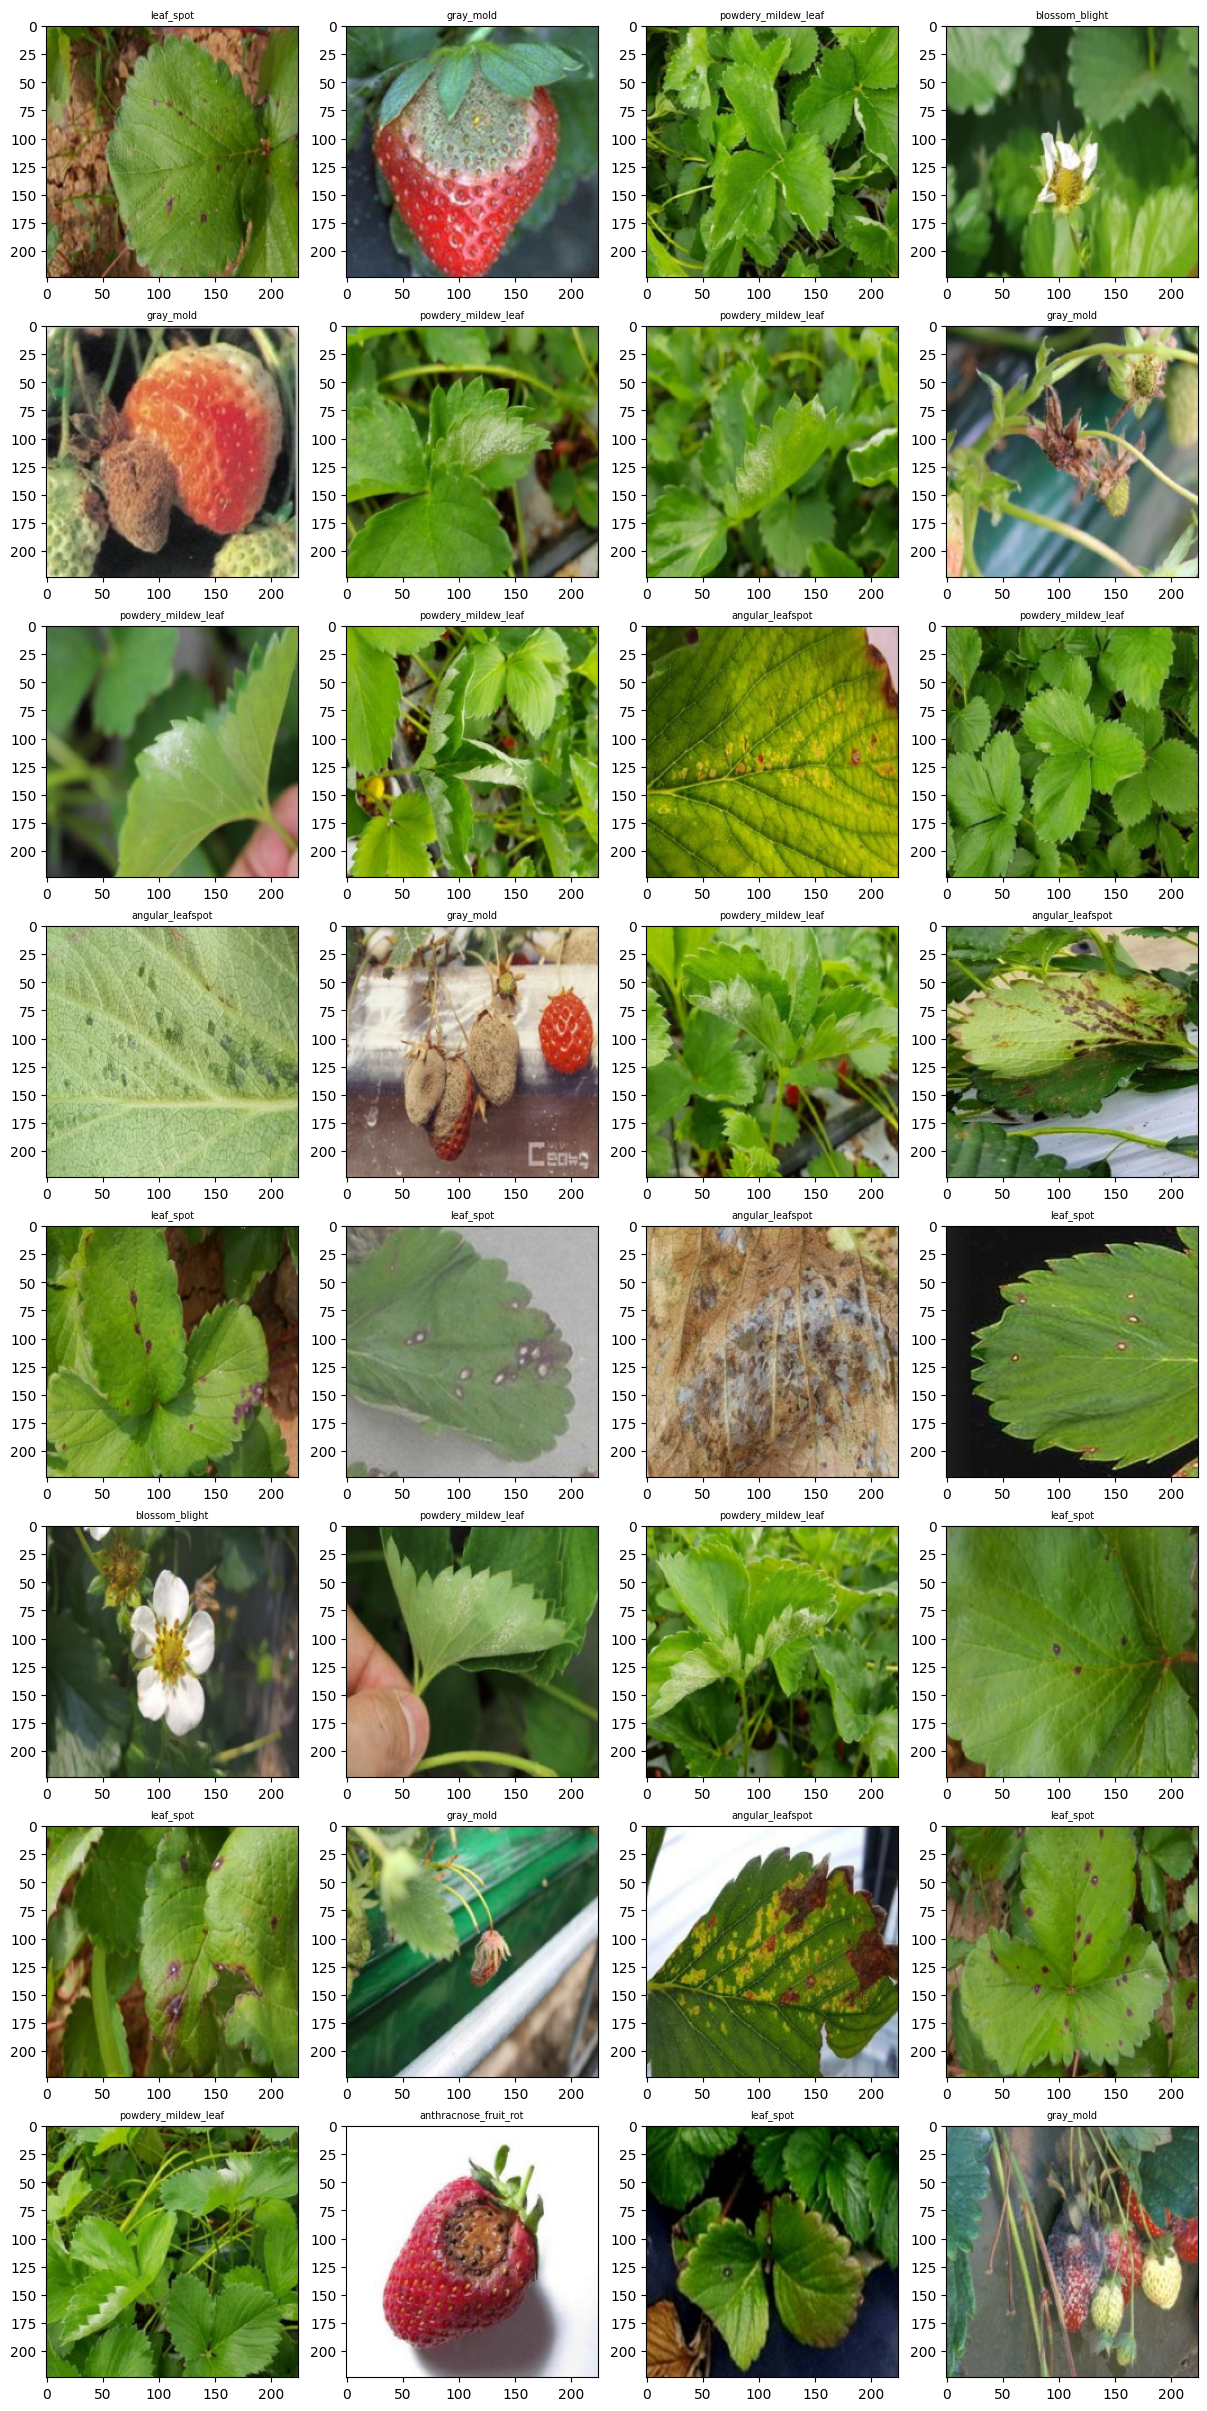

In [98]:
import math

BATCH_SIZE = 32

train_dl = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=True)


## -- for sanity check --
ncols = 4
nrows = math.ceil(BATCH_SIZE/ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows),
                         constrained_layout=True)
axes = axes.flatten() # (16,)

images, labels = next(iter(train_dl)) # (16, 3, 280, 280)

category = ['angular_leafspot', 'leaf_spot', 'anthracnose_fruit_rot',
              'blossom_blight', 'powdery_mildew_fruit', 'powdery_mildew_leaf',
              'gray_mold']

for ax, image, label in zip(axes, images, labels):
    img_denorm = image * imagenet_std + imagenet_mean
    img_denorm = img_denorm.clamp(0.0, 1.0)
    img_denorm_np = img_denorm.permute(1, 2, 0).cpu().numpy()
    
    ax.imshow(img_denorm_np)
    ax.set_title(f"{category[label.item()]}", fontsize=7)

plt.show()

In [99]:
valid_dl = DataLoader(dataset=ds_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(dataset=ds_test, batch_size=BATCH_SIZE, shuffle=True)

## STEP 2 – Import VGG16 and inspect architecture

Pay attention to the three main blocks:

* `features` – all convolution + pooling layers
* `avgpool` – adaptive/global pooling before the classifier
* `classifier` – the fully connected layers at the end


## STEP 3 – Build the strawberry-specific VGG16 (transfer learning)


1. **Resize + normalize** (we already did that).
2. **Freeze** the `features` (and usually `avgpool`) so we don’t change the convolution filters.
3. **Replace the `classifier`** by a new small network that outputs your number of classes.
4. Only train those new classifier parameters.

In [100]:
from torchvision import models

# ----- 1. Load pretrained ResNet18 -----
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [101]:
import torch.nn.functional as F
from torchvision import models
from torch import optim

# Set device (if not already done):
def get_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

     # ----- 1. Load pretrained ResNet18 -----
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # (optional) keep it explicit like in the book
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    # ----- 2. Freeze the feature extractor -----
    for param in model.parameters():
        param.requires_grad = False   # freeze everything first
        

    # ----- 3. Replace the classifier (fc) head -----
    # ResNet18's last feature dim is 512
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        
        nn.Linear(64, len(category)) # multi-class output
    )
    # new layers have requires_grad=True by default → only head will train

    model = model.to(device)
    
    # ----- 4. Loss & optimizer -----
    # loss + optimizer for multi-class we use CrossEntropy
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.8,
        patience=3,
        threshold=0.05,
        min_lr=1e-7,
        threshold_mode='abs'
    )

    return model, loss_fn, optimizer, scheduler

In [102]:
from torchsummary import summary

model, loss_fn, optimizer, sched = get_model()

# get the summary of the model so far
summary(model, input_data=(3, 224, 224), depth=2)
# print(model)

Using device: cuda
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          (73,984)
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          (73,984)
├─Sequential: 1-6                        [-1, 128, 28, 28]         --
|    └─BasicBlock: 2-3                   [-1, 128, 28, 28]         (230,144)
|    └─BasicBlock: 2-4                   [-1, 128, 28, 28]         (295,424)
├─Sequential: 1-7                        [-1, 256, 14, 14]         --
|    └─BasicBlock: 2-5                   [-1, 256, 14, 14]         (919,040)
|    └─BasicBlock: 2-6   

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          (73,984)
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          (73,984)
├─Sequential: 1-6                        [-1, 128, 28, 28]         --
|    └─BasicBlock: 2-3                   [-1, 128, 28, 28]         (230,144)
|    └─BasicBlock: 2-4                   [-1, 128, 28, 28]         (295,424)
├─Sequential: 1-7                        [-1, 256, 14, 14]         --
|    └─BasicBlock: 2-5                   [-1, 256, 14, 14]         (919,040)
|    └─BasicBlock: 2-6                   [-1

In [103]:
# images, labels = next(iter(train_dl)) # (16, 3, 280, 280)

# print(f"images.shape: {images.shape}, labels.shape :{labels.shape}")

# image = images[0]
# ## -- just for display --
# display_image = image * imagenet_std + imagenet_mean
# plt.figure(figsize=(7, 7))
# plt.imshow(display_image.permute(1, 2, 0).cpu().numpy())
# plt.title(f"{category[label.item()]}")
# plt.show()

# print(f"image.shape: {image.shape}")
# single_image_batch = image.unsqueeze(0)

# # -- prepare the image to pass through the network -- 
# single_image_batch = single_image_batch.to(device)
# print(f"single_image_batch.shape:{single_image_batch.shape}")

# # for i, layer in enumerate(vgg16.children()):
# #     print(f"{i:2d}: {layer}")
# feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)

# # -- pass the (1 image) batch through the network features extractor -- 
# with torch.inference_mode():
#     feats_b = feature_extractor(single_image_batch)

# print(feats_b.shape)    # should be [1, 512, 7, 7] for VGG-16

# Bs, Ch, Ht, Wd = feats_b.shape
# ncols = 8
# nrows = math.ceil(Ch/ncols)

# ## -- extract the image from the batch -- 
# feats_img = feats_b[0]

# print(f"XX: {feats_img.shape}")
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows),
#                          constrained_layout=True)

# for i, ax in enumerate(axes.flat):
#     if i > Ch:
#         ax.axis('off')
#         continue
#     ax.imshow(feats_img[i].cpu().numpy())
#     ax.set_title(f"Ch#{i}", fontsize=6)
# plt.show()


In [104]:
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    correct = (preds == targets).float().sum()
    total = targets.size(0)
    return correct/total 

In [105]:
def train_one_epoch(model, loss_fn, optimizer, train_dl, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_images_consumed = 0
    
    for images, targets in train_dl:
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = loss_fn(logits, targets)
        
        loss.backward()
        optimizer.step()
        
        with torch.inference_mode():
            batch_acc = accuracy_from_logits(logits, targets)
            batch_size = targets.size(0)
            
            running_loss += loss.item() * batch_size
            running_acc += batch_acc.item() * batch_size
            
            total_images_consumed += batch_size
    
    epoch_loss = running_loss/total_images_consumed
    epoch_acc = (running_acc/total_images_consumed) * 100
    
    return epoch_loss, epoch_acc            
        

def validate_one_epoch(model, loss_fn, valid_dl, device):
    model.eval()
    
    running_loss = 0.0
    running_acc = 0.0
    total_images_consumed = 0
    
    with torch.inference_mode():
        for images, targets in valid_dl:
            images = images.to(device)
            targets = targets.to(device)
            
            logits = model(images)
            loss = loss_fn(logits, targets)
            
            batch_size = targets.size(0)
            batch_acc = accuracy_from_logits(logits, targets)
            
            running_acc += batch_acc.item() * batch_size
            running_loss += loss.item() * batch_size
            
            total_images_consumed += batch_size
        
    epoch_loss = running_loss/total_images_consumed
    epoch_acc = (running_acc/total_images_consumed) * 100
    
    return epoch_loss, epoch_acc


def fit(model, loss_fn, optimizer, train_dl, valid_dl, epochs=50, verbose_every=5, sched=None):
    history = { "train_loss": [], "train_acc": [],
                "valid_loss": [], "valid_acc": [], 
                "lr": [] }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for ep in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, loss_fn, optimizer, train_dl, device)
        
        valid_loss, valid_acc = validate_one_epoch(model, loss_fn, valid_dl, device)
        
        if sched is not None:
            sched.step(valid_loss)
        
        current_lr = optimizer.param_groups[0]["lr"]
            
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        history["lr"].append(current_lr)
        
        if verbose_every > 0:
            should_print = ep == 1 or ep == epochs or ep % verbose_every == 0
        else:
            should_print = False
            
        if should_print:
            print(f"Epoch {ep:3d} |Train loss: {train_loss:.4f}, Train acc: {train_acc:3.2f}% |"
                  f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:3.2f}% |lr={current_lr:.7f}")
            
    return history

In [106]:
model, loss_fn, optimizer, sched = get_model()

hist = fit(model=model, loss_fn=loss_fn, optimizer=optimizer, train_dl=train_dl,
           valid_dl=valid_dl, epochs=30, verbose_every=5, sched=sched)

Using device: cuda
Epoch   1 |Train loss: 1.0114, Train acc: 65.50% |Valid loss: 0.3362, Valid acc: 86.54% |lr=0.0010000
Epoch   5 |Train loss: 0.2244, Train acc: 90.86% |Valid loss: 0.2194, Valid acc: 91.60% |lr=0.0010000
Epoch  10 |Train loss: 0.1595, Train acc: 94.57% |Valid loss: 0.1552, Valid acc: 94.43% |lr=0.0008000
Epoch  15 |Train loss: 0.1163, Train acc: 96.32% |Valid loss: 0.1281, Valid acc: 95.75% |lr=0.0006400
Epoch  20 |Train loss: 0.0950, Train acc: 96.94% |Valid loss: 0.1014, Valid acc: 96.46% |lr=0.0005120
Epoch  25 |Train loss: 0.0836, Train acc: 97.46% |Valid loss: 0.1343, Valid acc: 95.85% |lr=0.0004096
Epoch  30 |Train loss: 0.0724, Train acc: 97.72% |Valid loss: 0.0992, Valid acc: 97.06% |lr=0.0003277


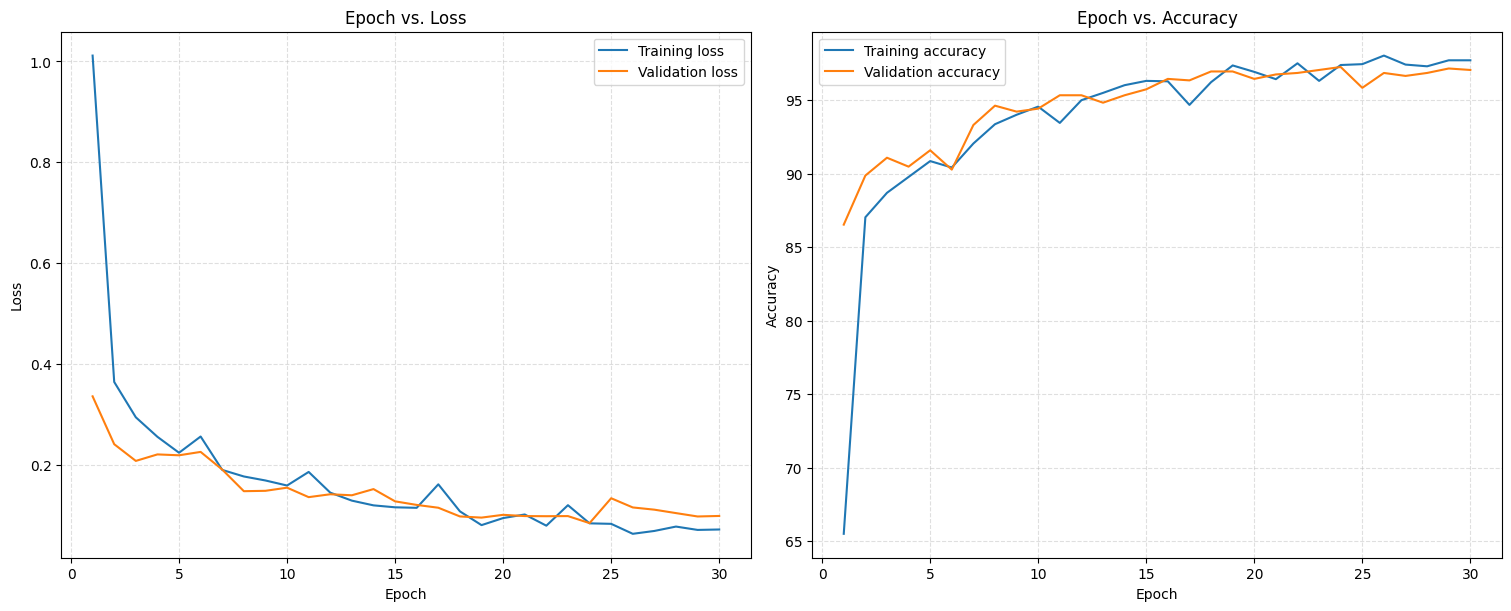

In [107]:
def plot_loss_acc(hist, every=5):
    
    epochs = np.arange(1, len(hist["train_loss"]) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,6), constrained_layout=True)
    
    ax = axes[0]
    ax.plot(epochs[::every], hist["train_loss"], label="Training loss")
    ax.plot(epochs[::every], hist["valid_loss"], label="Validation loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Epoch vs. Loss")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    
    ax = axes[1]
    ax.plot(epochs[::every], hist["train_acc"], label="Training accuracy")
    ax.plot(epochs[::every], hist["valid_acc"], label="Validation accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Epoch vs. Accuracy")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    
    plt.show()

plot_loss_acc(hist, every=1)
    

In [108]:
device = torch.device("cuda")
test_loss, test_acc = validate_one_epoch(model, loss_fn, test_dl, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:3.2f}")

Test loss: 0.0937, Test accuracy: 96.90


In [109]:
# collect all the data for the confusion matrix

def collect_data_for_cm(dl=None, device=device):
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.inference_mode():
        for images, targets in dl:
            images = images.to(device)
            targets = targets.to(device)
            
            logits = model(images)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    print(f"Examined {all_targets.shape[0]} samples")
    
    return all_preds, all_targets

In [110]:
all_preds, all_targets = collect_data_for_cm(valid_dl, device)

Examined 988 samples


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

all_preds, all_targets = collect_data_for_cm(valid_dl, device)

cm = confusion_matrix(all_targets, all_preds)
# print(cm)
# print(cm.shape)

Examined 988 samples
[[184   2   0   0   0   0   0]
 [  3 224   0   0   0   2   1]
 [  0   0  39   0   2   0   4]
 [  0   0   0  83   0   0   0]
 [  0   0   1   0  48   0   6]
 [  0   0   0   0   0 213   0]
 [  0   0   2   0   6   0 168]]
(7, 7)


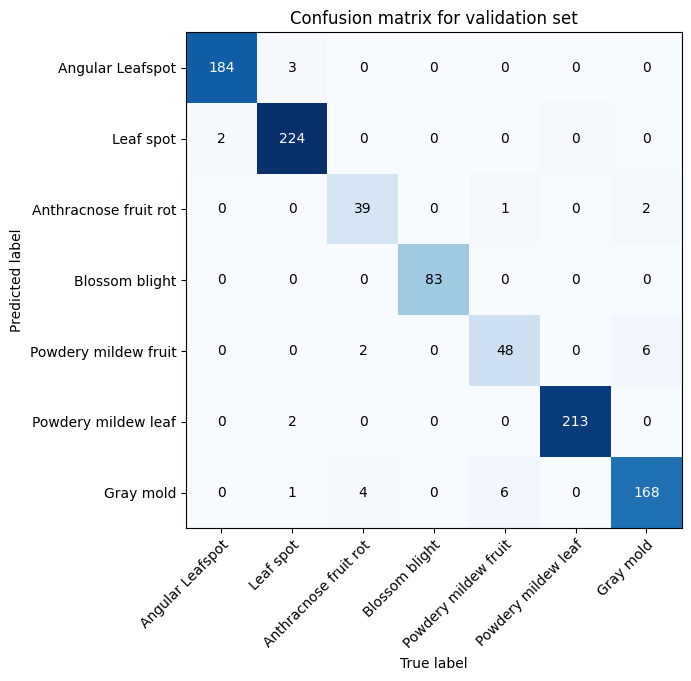

In [112]:
def plot_cm(cm=None, classes=None, data_type=None):
    if cm is None or classes is None or data_type is None:
        return
    
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    # ax.figure.colorbar(im, ax=ax)
    
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel='True label',
        ylabel='Predicted label',
        title=f'Confusion matrix for {data_type}'
    )
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    thresh = cm.max()/2.0
    for col in range(cm.shape[0]):
        for row in range(cm.shape[1]):
            ax.text(row, col, cm[row, col], ha="center", va="center", color="white" if cm[row, col] > thresh else "black") 
       
    plt.tight_layout()
    plt.show()

plot_cm(cm, valid_dl.dataset.classes, "validation set")

In [113]:
from sklearn.metrics import classification_report

report = classification_report(all_targets, all_preds, target_names=valid_dl.dataset.classes, digits=3)
print(report)

                       precision    recall  f1-score   support

     Angular Leafspot      0.984     0.989     0.987       186
            Leaf spot      0.991     0.974     0.982       230
Anthracnose fruit rot      0.929     0.867     0.897        45
       Blossom blight      1.000     1.000     1.000        83
 Powdery mildew fruit      0.857     0.873     0.865        55
  Powdery mildew leaf      0.991     1.000     0.995       213
            Gray mold      0.939     0.955     0.946       176

             accuracy                          0.971       988
            macro avg      0.956     0.951     0.953       988
         weighted avg      0.971     0.971     0.971       988

